# Chapter 6 - Linear Model Selection and Regularization

When we build a model we can use many predictors but we may not know in advance which predictor is more relevant for the predictions we are interested in. There are three approaches to select the models and the predictors: subset selection, shrinkage, also known as regularization, and dimension reduction.

## Subset selection
Subset selection consists of sistematically trying all the predictors, adding or removing them and then comparing the accuracy of all of the resulting models, for example by comparing their residual sum of squares (RSS) on the full available data set 

$$RSS = \sum_{i=1}^{n}(y_i - \hat{f}(x_i))^2$$

where

$$\hat{f}(x_1,..,x_p) = \beta_0 + \sum_{j=1}^{p} \beta_j x_j$$

or with other techniques such as the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) that allows to adjust the accuracy of models, taking into account the number of observations, the number of predictors, their variances.

### 6.5.1 Best Subset Selection
We use the 'Hitters' data set from the ISLR package to show how to implement the best subset selection method. The goal is to predict the salary of a baseball player from a set of predictors.

In [68]:
library(ISLR)
names(Hitters); dim(Hitters)
Hitters <- na.omit(Hitters) # remove all rows with missing value for any observations
dim(Hitters)

[1] "AtBat"     "Hits"      "HmRun"     "Runs"      "RBI"       "Walks"    
 [7] "Years"     "CAtBat"    "CHits"     "CHmRun"    "CRuns"     "CRBI"     
[13] "CWalks"    "League"    "Division"  "PutOuts"   "Assists"   "Errors"   
[19] "Salary"    "NewLeague"

[1] 263  20

[1] 263  20

We start by fitting models containing only one predictor and selecting the one that has the best accuracy, e.g. lowest RSS. We repeat the procedure by fitting the models that can be built with two predictors and so forth till the last model built with all the predictors. The last step is the selection of the model with the best accuracy among all the best models fitted with a sub set of the predictors. . The total number of models fitted with this method is $2^p$, where p is the total number of predictors. The models are fitted We can use dfferent statistics to select the model: RSS, $C_p$, $R^2$, AIC, BIC. All this step are implemented in the 'leaps' R library. 

In [20]:
library(leaps)
regfit.full <- regsubsets(Salary ~ ., data = Hitters, nvmax = 19, method = "exhaustive")
reg.summary <- summary(regfit.full)
reg.summary$rss

[1] 36179679 30646560 29249297 27970852 27149899 26194904 25906548 25136930
 [9] 24814051 24500402 24387345 24333232 24289148 24248660 24235177 24219377
[17] 24209447 24201837 24200700

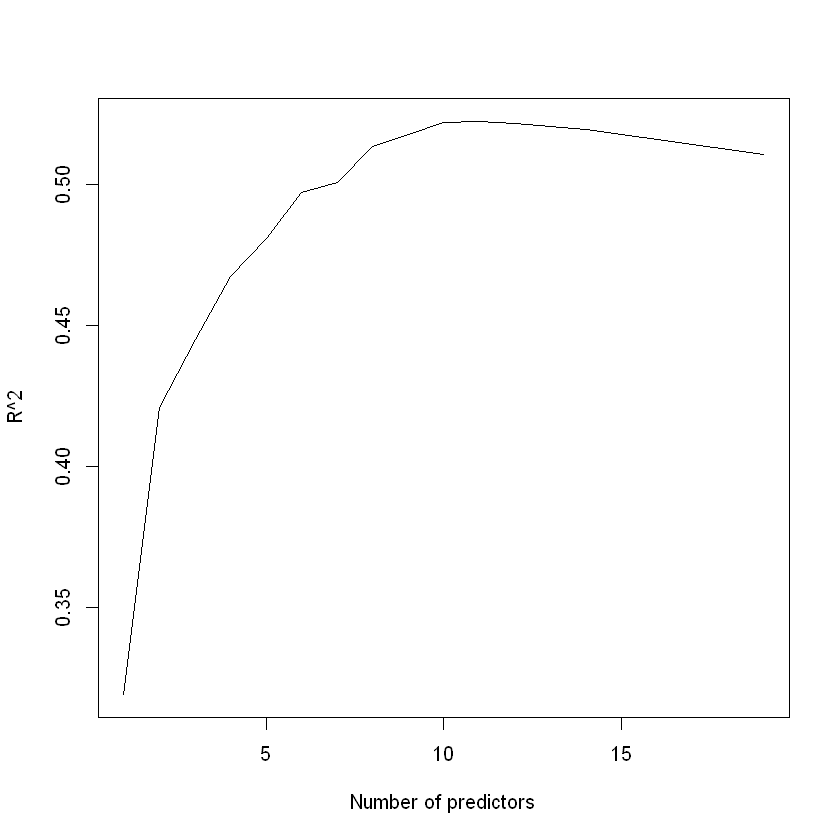

In [21]:
#par(mfrow=c(2,2))
plot(reg.summary$adjr2, xlab = "Number of predictors", ylab = "R^2", type = "l")

In [8]:
maxR2 <- which.max(reg.summary$adjr2)
maxR2 # model with the number of parameters that has the best accuracy
#points(11, reg.summary$adjr2[maxR2], col = "red", cex = 2, pch = 20)

[1] 11

We can see the variables that are used in the best models with each number of predictors. 

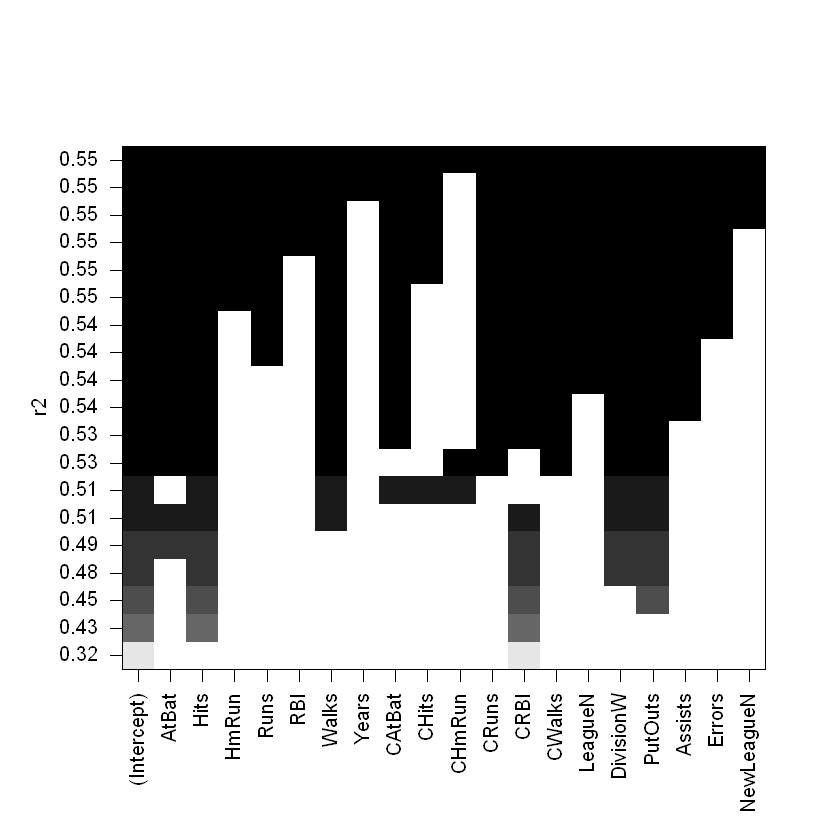

In [9]:
plot(regfit.full, scale = "r2")

### 6.5.2 Forward and Backward Stepwise Selection
The best subset selection model is computationally infeasable when the number of predictors is large. In forward and backward selection methods we try to limit the number of models. In forward selection we first fit a model for each predictor, then we select the best one and we repeat the operation using the predictor selected in the previous step and another one to see whether a model with two predictors has a better accuracy. The procedure is repeated till the last model with all the p predictors. The procedure for the backward selection model is similar but it starts by fitting a model with all the predictors, then the model with all but one predictors and so forth. The number of models fitted for both methods is $1 + \frac{p(p + 1)}{2}$.

We can see the predictors used in each of the best model. For example 'CRBI' is the predictor used for the best 1-predictor model. 

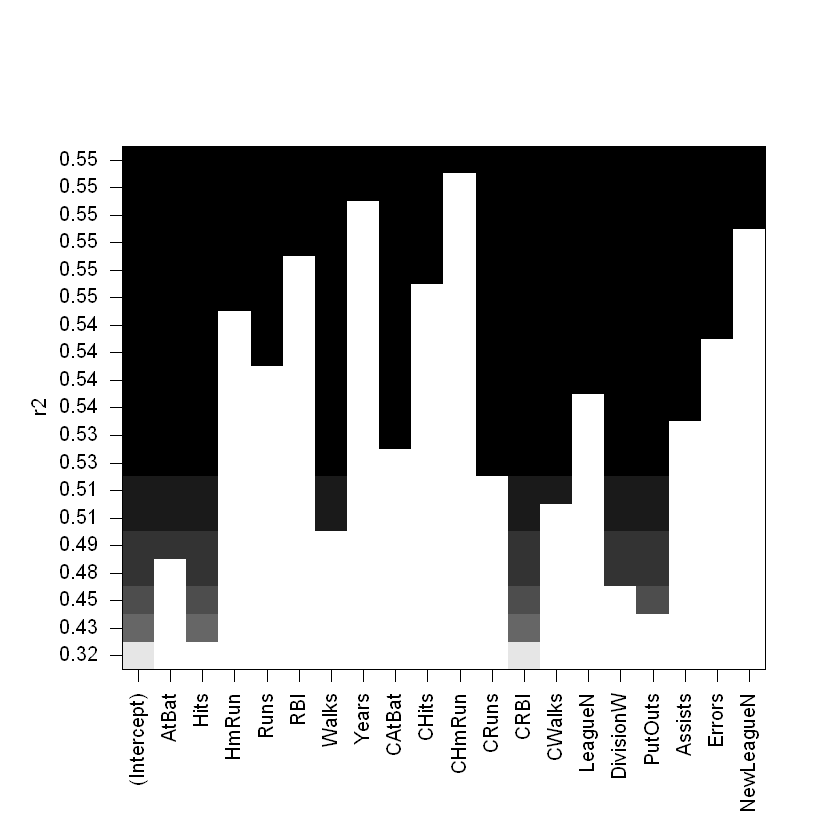

In [10]:
regfit.fwd <- regsubsets(Salary ~ ., data = Hitters, nvmax = 19, method = "forward")
plot(regfit.fwd, scale = "r2")

### 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation
So far we have used all the available observation to train a model and compute its residual sum of squares (RSS) to estimate its accuracy. We have also used other statistics, such as $R^2$ or $C_p$, to adjust the accuracy estimate provided by the RSS. Since these statistics are not easy to compute and not always reliable we can use the validation set approach and its variants instead. First we split the observations into a training set and a test set, then we fit our linear models using the best subset selection method with the training set.  

In [62]:
set.seed(1)
train <- sample(c(TRUE, FALSE), nrow(Hitters), replace = TRUE) 
test <- ! train
regfit.best <- regsubsets(Salary ~ ., data = Hitters[train, ], nvmax = 19, method = "exhaustive") # best subset selection

At this point, as a result of the best subset selection method, we have a vector of the best model of each model size built using only one predictors up to the complete set of predictors.

In [63]:
test.mat <- model.matrix(Salary ~ ., data = Hitters[test, ]) # creates a matrix of the data
val.errors <- rep(NA, 19) # initializes the errors vector
for (i in 1:19) {
    coef_i <- coefficients(regfit.best, id = i)
    prediction <- test.mat[, names(coef_i)] %*% coef_i # matrix multiplication
    val.errors[i] <- mean((Hitters$Salary[test] - prediction)^2)
}

We select the model with the lowest mean squared error on the test set.

In [66]:
best_model <- which.min(val.errors)
coefficients(regfit.best, best_model)

(Intercept)        AtBat         Hits        Walks        CRuns       CWalks 
  67.1085369   -2.1462987    7.0149547    8.0716640    1.2425113   -0.8337844 
   DivisionW      PutOuts 
-118.4364998    0.2526925

## Shrinkage (Regularization)
The shrinkage method consists of putting a constrain on the values that can be bound to the parameters $\beta_i$. Since the coefficients $\beta_i$ in a linear model are estimated using the least squares method, by minimizing the residual sum of squares

$$\frac{\partial RSS}{\partial \beta_i} = 0$$

we can add a term to RSS that we can use to tune the values of $\beta_i$ coefficients. The most common way is to add a penalty term that is the sum of the squared coefficients so that, instead of RSS, the function to be minimized is

$$RSS + \lambda \sum_{j=1}^{p}\beta_j^2$$

We can then use the parameter $\lambda$ to shrink the values of the coefficients towards zero. The technique of adding a term with squared coefficients to the expression to be minimized, or L2 norm of the $\beta$ vector, is called Ridge Regression or [Tikhonov Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)). 

Ridge Regression does not completely set any coefficient to zero so it cannot be used to select the predictors. Using a different penalty term, the L1 norm of the $\beta$ vector, will force some of the coefficient to be exactly zero. The quantity to be minimized is

$$RSS + \lambda \sum_{j=1}^{p}|\beta_j|$$

The technique is called Lasso (Least Absolute Shrinkage and Selection Operator). 

### 6.6.1 Ridge Regression

In [75]:
X <- model.matrix(Salary ~ ., data = Hitters)[, -1] # matrix of the data set without the 1st column 'Salary'
y <- Hitters$Salary

In [81]:
library(glmnet)
grid <- 10^seq(10, -2, length = 100) # generates a sequence of 100 numbers from 10^10 to 10^-2
ridge.mod <- glmnet(X, y, alpha = 0, lambda = grid)

## Dimension Reduction
This technique consists of mapping the predictors in the p-dimensional space to a subspace of dimension M < p, by finding a linear transformation of the predictors. The next step is to fit the linear model defined using the transformed M predictors. We can represent our linear model using vectors x and y, for the predictor and the response, and a diagonal matrix B for the coefficients, so that the linear model can be written as

$$y = B x$$

We can then define a linear transformation $\Phi$ of the predictor 

$$z = \Phi x$$

We fit the linear model for the transformed predictors  

$$y = \Theta z$$

and by replacing z we have

$$y = \Theta \Phi x$$

that is 

$$B = \Theta \Phi$$
